# Training Set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
%matplotlib inline

### Read raw training data

In [2]:
amazon = pd.read_csv('../amazon_data/raw_data_train.csv')
print(amazon.shape)

(364000, 14)


In [3]:
print(amazon.head())
print(amazon['helpful'].mean())

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId   ProfileName  \
0      123198        264718  264719  B002OFZM8O  A2AM5HNN5MGZNN       MWCobra   
1      385036        148245  148246  B000PJMRWU  A32RJEXJ9QMFQZ          chen   
2      120585        515447  515448  B001ONVOM0  A3LMNSDKLGNQY4   H. Roettger   
3      232172        214925  214926  B006N3I8PC  A24XI8OFQUS92Q   K. Sizemore   
4      387256        162056  162057  B000ER3QM8   AOFU0B9HARNQR  PitBullMommy   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     0                       0      5  1312243200   
1                     1                       2      1  1286236800   
2                     1                       2      5  1255910400   
3                     0                       0      5  1342656000   
4                     0                       0      1  1345766400   

                                             Summary  \
0                        Oh yes.  Th

### Feature extraction on natural language data

In [ ]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = amazon.Text.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())

In [4]:
# vectorize Bag of Words from review text; as sparse matrix
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer(n_features=2 ** 17, non_negative=True)
X_hv = hv.fit_transform(amazon.Text)
print(X_hv.shape)

/Users/aaronhill/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/Users/aaronhill/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


(364000, 131072)


In [5]:
# We want to be able to use this model fit on other data (the test set)
# So let's save a copy of this instance of HashingVectorizer to be able to transform other data with this fit
# http://scikit-learn.org/stable/modules/model_persistence.html
joblib.dump(hv, 'hv.pkl') # pickle

['hv.pkl']

In [6]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
X_tfidf = transformer.fit_transform(X_hv)

joblib.dump(transformer, 'transformer.pkl') # pickle

['transformer.pkl']

In [7]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Create additional quantitative features

In [8]:
# features from Amazon.csv to add to feature set
amazon['reviewLen'] = amazon['Text'].str.len()

X_quant_features = amazon[["Score", "reviewLen"]]
print(X_quant_features.head(10))
print(type(X_quant_features))

   Score  reviewLen
0      5        283
1      1        183
2      5        291
3      5        100
4      1        245
5      1        696
6      1        317
7      5        318
8      5        151
9      5        122
<class 'pandas.core.frame.DataFrame'>


### Combine all quantitative features into a single sparse matrix

In [9]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(364000, 131074)


### Create `X`, scaled matrix of features

In [10]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X = sc.fit_transform(X_matrix)
print(X.shape)

joblib.dump(sc, 'sc.pkl') # pickle

(364000, 131074)


['sc.pkl']

### create `y`, vector of Labels

In [11]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


### fit models

In [12]:
from my_measures import BinaryClassificationPerformance

In [13]:
# MODEL: SVM, linear
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X, y)
joblib.dump(svm, 'svm.pkl') # pickle

svm_performance = BinaryClassificationPerformance(svm.predict(X), y, 'svm')
svm_performance.compute_measures()
print(svm_performance.performance_measures)

/Users/aaronhill/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


{'Pos': 26582, 'Neg': 337418, 'TP': 11850, 'TN': 325157, 'FP': 12261, 'FN': 14732, 'Accuracy': 0.92584340659340658, 'Precision': 0.49147691924847581, 'Recall': 0.44579038447069447, 'desc': 'svm'}


In [14]:
# MODEL: logistic regression
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log', n_iter=50, alpha=0.00001)
lgs.fit(X, y)
joblib.dump(lgs, 'lgs.pkl') # pickle

lgs_performance = BinaryClassificationPerformance(lgs.predict(X), y, 'lgs')
lgs_performance.compute_measures()
print(lgs_performance.performance_measures)

/Users/aaronhill/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


{'Pos': 26582, 'Neg': 337418, 'TP': 13479, 'TN': 324641, 'FP': 12777, 'FN': 13103, 'Accuracy': 0.92890109890109895, 'Precision': 0.51336837294332727, 'Recall': 0.50707245504476717, 'desc': 'lgs'}


In [15]:
# MODEL: Naive Bayes
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X, y)
joblib.dump(nbs, 'nbs.pkl') # pickle

nbs_performance = BinaryClassificationPerformance(nbs.predict(X), y, 'nbs')
nbs_performance.compute_measures()
print(nbs_performance.performance_measures)

{'Pos': 26582, 'Neg': 337418, 'TP': 17202, 'TN': 295255, 'FP': 42163, 'FN': 9380, 'Accuracy': 0.85839835164835165, 'Precision': 0.28976669754906087, 'Recall': 0.64712963659619294, 'desc': 'nbs'}


In [16]:
# MODEL: Ridge Regression Classifier
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X, y)
joblib.dump(rdg, 'rdg.pkl') # pickle

rdg_performance = BinaryClassificationPerformance(rdg.predict(X), y, 'rdg')
rdg_performance.compute_measures()
print(rdg_performance.performance_measures)

{'Pos': 26582, 'Neg': 337418, 'TP': 7923, 'TN': 336780, 'FP': 638, 'FN': 18659, 'Accuracy': 0.94698626373626371, 'Precision': 0.92547599579488382, 'Recall': 0.29805883680686179, 'desc': 'rdg'}


In [17]:
# MODEL: Perceptron
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X, y)
joblib.dump(prc, 'prc.pkl') # pickle

prc_performance = BinaryClassificationPerformance(prc.predict(X), y, 'prc')
prc_performance.compute_measures()
print(prc_performance.performance_measures)

/Users/aaronhill/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


{'Pos': 26582, 'Neg': 337418, 'TP': 11895, 'TN': 323880, 'FP': 13538, 'FN': 14687, 'Accuracy': 0.92245879120879126, 'Precision': 0.46769944560217042, 'Recall': 0.44748325934843125, 'desc': 'prc'}


### ROC plot to compare performance of various models and fits

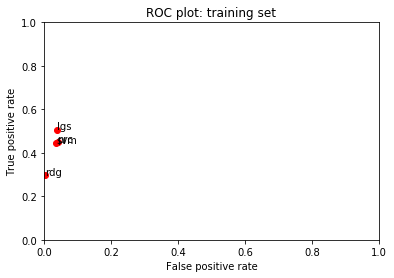

In [18]:
#fits = [svm_performance, lgs_performance, nbs_performance, rdg_performance, prc_performance]
fits = [svm_performance, lgs_performance, rdg_performance, prc_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'ro')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()